In [19]:
import os
import pandas as pd
from typing import List

import tensorflow as tf
import tensorflow_ranking as tfr
import tensorflow_recommenders as tfrs

from src.tower import Tower
from src.retrieval import Retrieval
from src.embedding import Embedding
from src.recommender import RecommenderModel
from src.ranking import ListwiseRanking
from src.utils.utilities import (
    sample_listwise,
    train_test_split,
    plot_history,
)

RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)
os.environ['TF_USE_LEGACY_KERAS'] = '1'

## Load Datasets

In [20]:
# Dataset size (options: 100k, 1m)
DATASET_SIZE: str = '100k'
N_RATINGS: int    = 100_000

# Load each dataset
users_df    = pd.read_parquet(f'data/{DATASET_SIZE}-users.parquet')
movies_df   = pd.read_parquet(f'data/{DATASET_SIZE}-movies.parquet')
ratings_df  = pd.read_parquet(f'data/{DATASET_SIZE}-ratings.parquet')

ratings_df = ratings_df.iloc[:N_RATINGS]

# Remove lists
movies_df.drop(columns=['movie_genres'], inplace=True)

In [21]:
# Handle missing values
movies_df.fillna(value=-1, inplace=True)

# Merge DataFrames
ratings_df = ratings_df.merge(users_df, on = 'user_id')
ratings_df = ratings_df.merge(movies_df, on = 'movie_id')

ratings_df.head()

,user_id,movie_id,timestamp,user_rating,user_gender,user_zip_code,user_bucketized_age,user_occupation_label,movie_title,movie_release_year
0,138,357,879024327,4.0,1,53211,45.0,4,One Flew Over the Cuckoo's Nest,1975
1,92,709,875654590,2.0,1,80525,25.0,5,Strictly Ballroom,1992
2,301,412,882075110,4.0,1,55439,18.0,17,"Very Brady Sequel, A",1996
3,60,56,883326919,4.0,1,06472,50.0,4,Pulp Fiction,1994
4,197,895,891409199,3.0,1,75094,50.0,18,Scream 2,1997


In [22]:
TRAIN_RATIO: float = 0.8

# Convert the DataFrame to TensorFlow Dataset
ratings_dataset = tf.data.Dataset.from_tensor_slices(dict(ratings_df.astype(str)))
movies_dataset  = tf.data.Dataset.from_tensor_slices(dict(movies_df.astype(str)))
users_dataset  = tf.data.Dataset.from_tensor_slices(dict(users_df.astype(str)))

ratings_dataset = ratings_dataset.map(lambda x: {
    'user_id':                  x['user_id'],
    'movie_id':                 x['movie_id'],
    'timestamp':                int(x['timestamp']),
    'user_rating':              float(x['user_rating']),
    'user_gender':              int(x['user_gender']),
    'user_zip_code':            x['user_zip_code'],
    'user_bucketized_age':      float(x['user_bucketized_age']),
    'user_occupation_label':    int(x['user_occupation_label']),
    'movie_title':              x['movie_title'],
    'movie_release_year':       x['movie_release_year'],
})

movies_dataset = movies_dataset.map(lambda x: {
    'movie_id':                 x['movie_id'],
    'movie_title':              x['movie_title'],
    'movie_release_year':       x['movie_release_year'],
})

users_dataset = users_dataset.map(lambda x: {
    'user_id':                  x['user_id'],
    'user_gender':              int(x['user_gender']),
    'user_zip_code':            x['user_zip_code'],
    'user_bucketized_age':      float(x['user_bucketized_age']),
    'user_occupation_label':    int(x['user_occupation_label']),
})

ratings_dataset.take(1).as_numpy_iterator().next()

{'user_id': b'138',
 'movie_id': b'357',
 'timestamp': 879024327,
 'user_rating': 4.0,
 'user_gender': 1,
 'user_zip_code': b'53211',
 'user_bucketized_age': 45.0,
 'user_occupation_label': 4,
 'movie_title': b"One Flew Over the Cuckoo's Nest",
 'movie_release_year': b'1975'}

In [23]:
# Split into train and validation sets
ratings_trainset, ratings_validset = train_test_split(
    dataset = ratings_dataset,
    train_size = TRAIN_RATIO,
    random_state = RANDOM_STATE,
    buffer_size = 10_000
)

print(f"Training data:\t", ratings_trainset.__len__().numpy())
print(f"Validation data:", ratings_validset.__len__().numpy())

Training data:	 8000
Validation data: 2000


In [24]:
ratings_trainset = sample_listwise(
    ratings_trainset,
    num_list_per_user = 50,
    num_examples_per_list = 5,
    seed = RANDOM_STATE
)

ratings_validset = sample_listwise(
    ratings_validset,
    num_list_per_user = 1,
    num_examples_per_list = 5,
    seed = RANDOM_STATE
)

## Create the Embedding Models

### User Embeddings

In [25]:
# For either integer or string categorical features, the
# `StringLookup` layer will create a vocabulary that maps
# each string value to an integer index followed by an
# embedding layer:
USER_STR_FEATURES: List[str] = ['user_id', 'user_zip_code']
USER_INT_FEATURES: List[str] = ['user_gender', 'user_bucketized_age', 'user_occupation_label']

# For text features, the `TextVectorization` layer will
# create a vocabulary that maps each token to an integer
# index followed by an embedding layer:
USER_TEXT_FEATURES: List[str] = []

# Timestamp features will be discretized into buckets
# and the `Discretization` layer will create a vocabulary
# for the embedding layer. The value will finally be
# normalized between 0 and 1:
USER_TIMESTAMP_FEATURES: List[str] = []

# Embedding layers will be applied to each of the specified 
# features, with all layers having the same dimensionality 
# as defined below:
USER_EMBEDDING_DIM: int = 64

In [26]:
user_embedding_model = Embedding(
    dataset             = users_dataset.batch(1_000),
    str_features        = USER_STR_FEATURES,
    int_features        = USER_INT_FEATURES,
    text_features       = USER_TEXT_FEATURES,
    timestamp_features  = USER_TIMESTAMP_FEATURES,
    embedding_dim       = USER_EMBEDDING_DIM,
)

### Movie Embeddings

In [27]:
# For either integer or string categorical features, the
# `StringLookup` layer will create a vocabulary that maps
# each string value to an integer index followed by an
# embedding layer:
MOVIE_STR_FEATURES: List[str] = ['movie_release_year', 'movie_title']
MOVIE_INT_FEATURES: List[str] = []

# For text features, the `TextVectorization` layer will
# create a vocabulary that maps each token to an integer
# index followed by an embedding layer:
MOVIE_TEXT_FEATURES: List[str] = []

# Timestamp features will be discretized into buckets
# and the `Discretization` layer will create a vocabulary
# for the embedding layer. The value will finally be
# normalized between 0 and 1:
MOVIE_TIMESTAMP_FEATURES: List[str] = []

# Embedding layers will be applied to each of the specified 
# features, with all layers having the same dimensionality 
# as defined below:
MOVIE_EMBEDDING_DIM: int  = 32

In [28]:
movie_embedding_model = Embedding(
    dataset             = movies_dataset.batch(1_000),
    str_features        = MOVIE_STR_FEATURES,
    int_features        = MOVIE_INT_FEATURES,
    text_features       = MOVIE_TEXT_FEATURES,
    timestamp_features  = MOVIE_TIMESTAMP_FEATURES,
    embedding_dim       = MOVIE_EMBEDDING_DIM,
)

## Create the Towers Models

### Query Tower

In [29]:
# The projection dimension determines the size of the feature 
# space for learning cross-features. By employing low-rank 
# techniques to approximate the weight matrices of the DCN, 
# we can effectively reduce both training and serving costs.
# More: https://www.tensorflow.org/recommenders/examples/dcn
QT_CROSS_PROJECTION_DIM: int = user_embedding_model.embeddings_output_dim / 4

# Larger and more complex models, though often delivering better 
# performance, generally require careful tuning. Nevertheless, it's 
# essential to include at least one dense layer in the tower to unify 
# the outputs from the embedding layers. This is necessary because 
# each tower may generate embeddings of varying sizes, depending on 
# the different features it processes:
# More: https://www.tensorflow.org/recommenders/examples/deep_recommenders
QT_DENSE_LAYERS: List[int] = [32]

In [30]:
# Deep & Cross Network
qt_cross_layer = tfrs.layers.dcn.Cross(
    projection_dim     = QT_CROSS_PROJECTION_DIM,
    kernel_initializer = "glorot_uniform"
)

query_tower = Tower(
    embedding_model = user_embedding_model,
    cross_layer     = qt_cross_layer,
    dense_layers    = QT_DENSE_LAYERS
)

### Candidate Tower

In [31]:
# The projection dimension determines the size of the feature 
# space for learning cross-features. By employing low-rank 
# techniques to approximate the weight matrices of the DCN, 
# we can effectively reduce both training and serving costs.
# More: https://www.tensorflow.org/recommenders/examples/dcn
CT_CROSS_PROJECTION_DIM: int = movie_embedding_model.embeddings_output_dim / 2

# Larger and more complex models, though often delivering better 
# performance, generally require careful tuning. Nevertheless, it's 
# essential to include at least one dense layer in the tower to unify 
# the outputs from the embedding layers. This is necessary because 
# each tower may generate embeddings of varying sizes, depending on 
# the different features it processes:
# More: https://www.tensorflow.org/recommenders/examples/deep_recommenders
CT_DENSE_LAYERS: List[int] = [32]

In [32]:
# Deep & Cross Network
ct_cross_layer = tfrs.layers.dcn.Cross(
    projection_dim     = CT_CROSS_PROJECTION_DIM,
    kernel_initializer = "glorot_uniform"
)

candidate_tower = Tower(
    embedding_model = movie_embedding_model,
    cross_layer     = ct_cross_layer,
    dense_layers    = CT_DENSE_LAYERS
)

## Define the Ranking Model

In [33]:
ranking_task = tfrs.tasks.Ranking(
    loss = tf.keras.losses.MeanSquaredError(),      # MSE
    # loss = tfr.keras.losses.PairwiseHingeLoss(),
    # loss = tfr.keras.losses.ListMLELoss(),
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(),    # RMSE
        tfr.keras.metrics.NDCGMetric(),             # NGCG
    ],
)

# We will use a ranking model to help train the 
# retrieval system. We will use the pointwise approach
# that assesses the relevance of individual items 
# or documents independently.
ranking_model = ListwiseRanking(
    query_tower     = query_tower,
    candidate_tower = candidate_tower,
    task            = ranking_task
)

## Recommender

In [39]:
RUN_EAGERLY: bool       = True     # Better debugging, slower training
LEARNING_RATE: float    = 0.1

model = ranking_model

optimizer = tf.keras.optimizers.Adagrad(learning_rate=LEARNING_RATE)
model.compile(optimizer = optimizer, run_eagerly=RUN_EAGERLY)

Epoch 1/50
26/26 [==============================] - 3s 115ms/step - root_mean_squared_error: 0.0000e+00 - ndcg_metric_1: 0.0000e+00 - loss: 7.4846 - regularization_loss: 0.0000e+00 - total_loss: 7.4846 - val_root_mean_squared_error: 1.0589 - val_ndcg_metric_1: 0.8749 - val_loss: 1.1213 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1213
Epoch 2/50
26/26 [==============================] - 3s 107ms/step - root_mean_squared_error: 0.0000e+00 - ndcg_metric_1: 0.0000e+00 - loss: 0.8437 - regularization_loss: 0.0000e+00 - total_loss: 0.8437 - val_root_mean_squared_error: 1.0843 - val_ndcg_metric_1: 0.8927 - val_loss: 1.1757 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.1757
Epoch 3/50
26/26 [==============================] - 3s 106ms/step - root_mean_squared_error: 0.0000e+00 - ndcg_metric_1: 0.0000e+00 - loss: 0.7729 - regularization_loss: 0.0000e+00 - total_loss: 0.7729 - val_root_mean_squared_error: 1.0327 - val_ndcg_metric_1: 0.8934 - val_loss: 1.0664 - val_regular

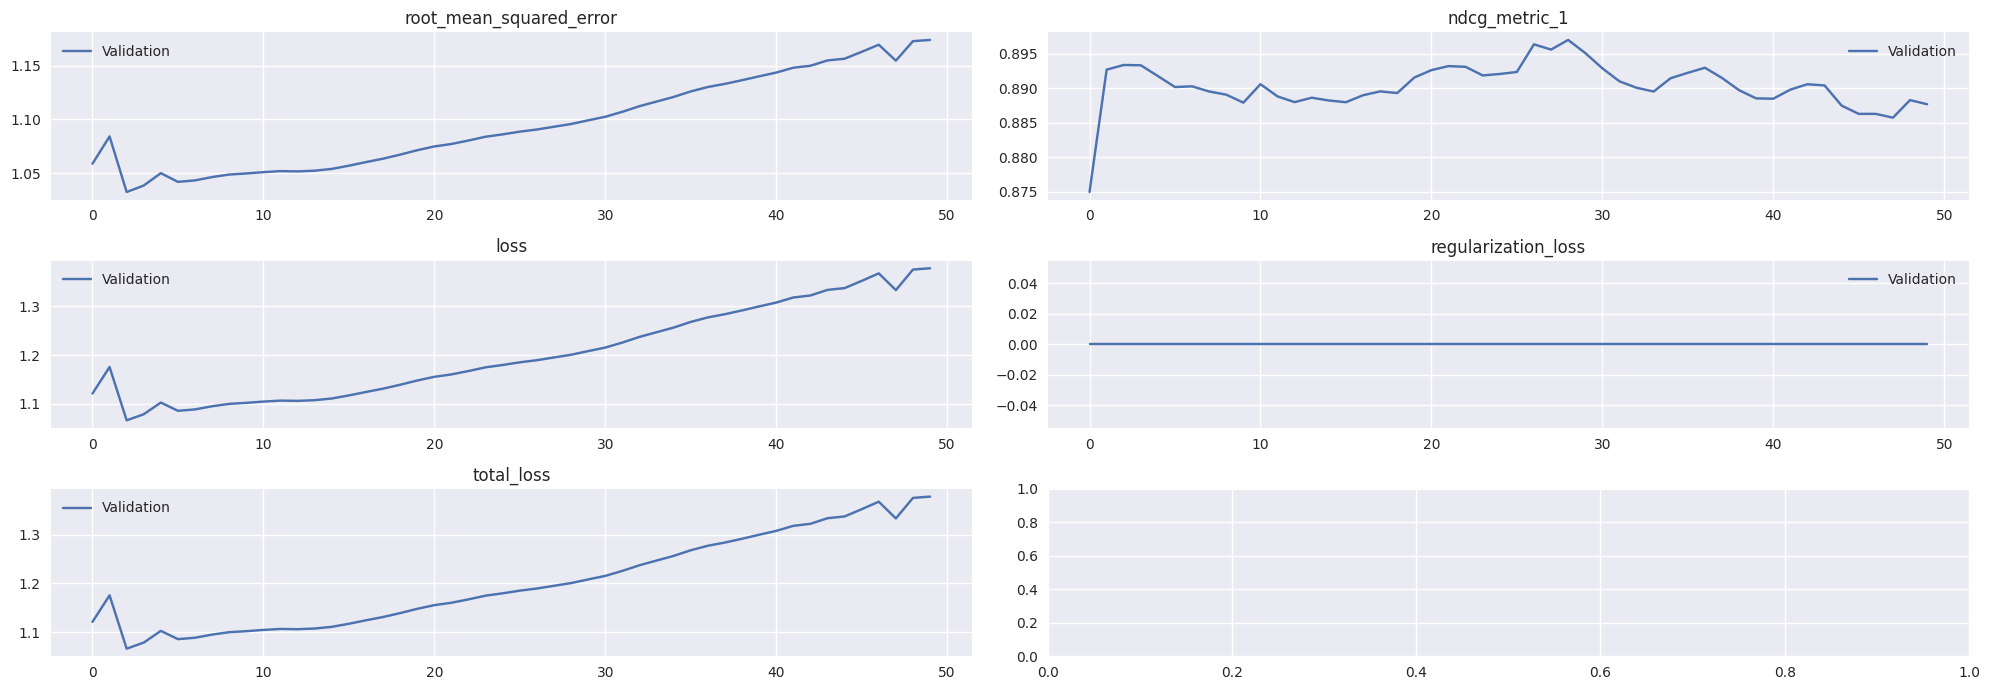

In [40]:
EPOCHS: int          = 50
VALIDATION_FREQ: int = 1

cached_ratings_trainset = ratings_trainset.shuffle(100_000).batch(1024).cache()
cached_ratings_validset = ratings_validset.batch(1024).cache()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'total_loss',
    patience = 10,
)

history = model.fit(
    cached_ratings_trainset,
    validation_data = cached_ratings_validset,
    validation_freq = VALIDATION_FREQ,
    epochs          = EPOCHS,
    callbacks = [
        early_stopping_callback
    ]
)

print(model.evaluate(cached_ratings_validset, return_dict=True, verbose=False))
plot_history(history = history, plot_training=False)